# Virtualizing Data Access: Towards "Cloud Native" Analysis Ready Data @ NSIDC

2025 NSIDC UWG meeting


### Standard file access (streaming data)

* Archival formats are inefficient to access over the network (NetCDF, HDF5, HDF4, GRIB)
* Native drivers are not optimized for cloud access
* Metadata logical unit is a file

### Virtualized data (metadata) access

* Cloud-like access for *compatible* datasets
* Zarr client libraries, this means we can bypass netcdf, hdf5 drivers.
* **FASTER access to cloud hosted data**
* Metadata logical unit (consolidation) can be assembled at different levels (data cubes)


In [1]:
import earthaccess as ea
import xarray as xr
import zarr

import pandas as pd
import fsspec
import re

import dask
from dask.distributed import Client, LocalCluster
from coiled import Cluster as CoiledCluster
import cartopy.crs as ccrs
import numpy as np

# for _ in (ea, vz, zarr, xr):
#     print(f"{_}: {_.__version__}")

In [2]:
auth = ea.login()

## Scaling horizontally with Dask

We still need to process potentially thousands of files so either locally or in the cloud we need a framework that helps us with the parallelization of these tasks.
Since Dask has been integrated into xarray and the rest of the Pangeo/Scientific Python data stack is the natural option to use (but not the only one).

In [3]:
cloud_opts = {
    "region": "us-west-2",
    "worker_vm_types": ["t3a.medium"],
    "spot_policy": "spot_with_fallback",
    # "arm": False,
    "name": "test-vd",
    "environ": {"EARTHDATA_TOKEN": auth.token["access_token"]}
}

In [4]:
def create_dask_cluster(environment="local",
                        n_workers=4,
                        cloud_opts={}):
    import logging
    
    if "client" in locals() and "cluster" in locals():
        return (client, cluster)
    else:
        if environment=="local":
            print("Creating new local Dask client")
            cluster = LocalCluster(
                n_workers=n_workers,
                threads_per_worker=1,
                silence_logs=logging.ERROR)
        else:
            print("Creating new Coiled Dask client")
            cluster = CoiledCluster(n_workers=n_workers,
                                    **cloud_opts)    

        client = Client(cluster)
        # obstore_plugin = RustacStorePlugin(obstore_opts)
        # client.register_plugin(obstore_plugin, name='rustac_store')
        return (client, cluster)

def silence_worker_warnings():
    import warnings
    import logging
    
    warnings.filterwarnings("ignore")
    for name in ["distributed", "xarray", "py.warnings", "fsspec", "h5netcdf", "h5py"]:
        logging.getLogger(name).setLevel(logging.ERROR)

In [5]:
client, cluster = create_dask_cluster(environment="local",
                                      n_workers=16,
                                      cloud_opts=cloud_opts)
client

Creating new local Dask client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 46.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46655,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46543,Total threads: 1
Dashboard: http://127.0.0.1:45963/status,Memory: 2.92 GiB
Nanny: tcp://127.0.0.1:40643,


In [6]:
%%capture
client.run(silence_worker_warnings)

## Virtualizing Access with Earthaccess + VirtualiZarr

### Background

Data virtualization works by extracting and [consolidating metadata](https://earthmover.io/blog/fundamentals-what-is-cloud-optimized-scientific-data/), this way we avoid the many small requests needed to understand and process the data in archival formats. The standard approach to extract file-level metadata still uses the native HDF5 drivers to read and collect this information and thus is a slow process. Back in 2020 Patrick Quinn (former ESDIS software architect) noticed that there is a semantic equivalence between Kerchunk metadata and the OPeNDAP dmrpp metadata and created a project called "zarr-eosdis-store" that translated this dmrpp into Zarr metadata at the file level. This project opened the way to what later became the integration we provide in earthaccess.

Another milestone for this work was started by Jinbo Wang (former DAAC scientist at PODAAC) who assigned Ayush Nag (Intern at JPL at the time and now at SpaceX) to work on the dmrpp integration with VirtualiZarr and earthaccess. Similar to `zarr-eosdis-store`, Ayush' integration parses the dmrpp files already produced for OPeNDAP and translates them into Zarr-quivalent "chunk manifests". There are 3 key advantages of this integration with earthaccess:

* No need to extract metadata (as this is slow) we just translate it.
* Researchers don't need to worry about finding the files, earthaccess `search_data()` results are the input for `open_virtual_mfdataset`
* We are not limited to work with one file at the time, we provide metadata concatenation that can be customized the same way we concatenate arrays using xarray!

We are building a pipeline to facilitate how virtual datacubes can be generated by data producers and researchers alike. We hope that by the end of the year (2025) we have a stable API that can be used to reproduce this workflow with more datasets. 

Let's try this with a dataset that fills the requirements for virtualization** [SPL4SMGP](https://nsidc.org/sites/default/files/documents/user-guide/multi_spl4smau-v008-userguide.pdf)


---
** Almost 


In [7]:
## The whole collection spanning 10 years of data
results  = ea.search_data(
    short_name="SPL4SMGP",
    version="008",
    provider="NSIDC_CPRD",
    cloud_hosted=True,
    temporal=("2015-03-01", "2025-10-01")
)
len(results)

30704

In [14]:
%%time 

r_ds = xr.open_dataset(ea.open(results[0:1], show_progress=False)[0], phony_dims='sort')
r_ds

CPU times: user 2.22 s, sys: 675 ms, total: 2.9 s
Wall time: 21.2 s


<xarray.Dataset> Size: 150MB
Dimensions:                  (phony_dim_2: 1, y: 1624, x: 3856)
Coordinates:
  * x                        (x) float64 31kB -1.736e+07 ... 1.736e+07
  * y                        (y) float64 13kB 7.31e+06 7.301e+06 ... -7.31e+06
Dimensions without coordinates: phony_dim_2
Data variables:
    EASE2_global_projection  (phony_dim_2) |S1 1B ...
    cell_column              (y, x) float64 50MB ...
    cell_lat                 (y, x) float32 25MB ...
    cell_lon                 (y, x) float32 25MB ...
    cell_row                 (y, x) float64 50MB ...
    time                     (phony_dim_2) datetime64[ns] 8B ...
Attributes:
    Comment:      HDF-5
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  CF
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv8010/...
    History:      File written by ldas2daac.x
    Institution:  NASA Global Modeling and Assimilation Office
    References:   see SMAP L4_SM Product Specification Documentation
    Source:       v18.1.0
    Title:        SMAP L4_SM Geophysical (GPH) Data Granule

Empirically, opening a single granule of this SMAP L4 dataset with xarray takes about 20 seconds (out of the cloud)

This means serially processing SPL4SMGP...

In [15]:
print(f"{round(sum([g.size() for g in results])/1024,2)} GB of data will take {round(len(results) * 20 / (60 * 60 * 24), 2)} days!")

4269.85 GB of data will take 7.11 days!


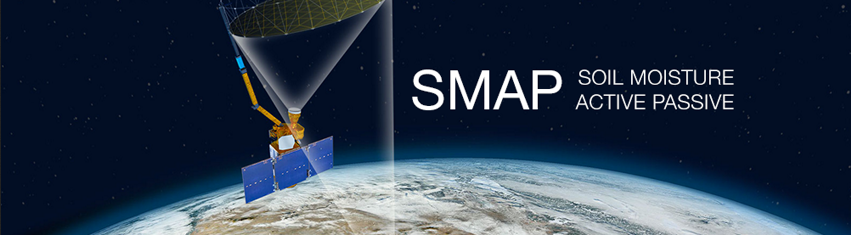


**Downloading and processing 4TB of data (broadband) ~= 18 hours to a day**
 * If we have the storage and compute available, downloading is not a bad option but we are creating copies that later need to be synced or potentially reprocessed.

Virtualized access is awesome when it works but:
 
**Requirements**

* Homogeneous data
  * compression
  * variable names
  * grids
  * chunking
* Chunk size:
  * Small chunks produce a lot of metadata
  * chunks on most collections are small
* CF conventions
  * help libraries understand the data
  * well defined dimensions
  * well defined coordinates

**Advantages**

* Bypassing the HDF5 limitations
  * Global thread lock (concurrency)
* Metadata consolidation
  * Whole collection
  * Area of Interest
  * Temporal
  * Combination of both if chunks align 


In [10]:
def preprocess_smap_SPL4SMGP(ds):
    fname = ds.attrs.get("Filename", "")
    actual_fname = fname.split("/")[-1]
    granules = ea.search_data(
        short_name="SPL4SMGP",
        version="008",
        cloud_hosted=True,
        granule_name=f"*{actual_fname}*"
    )
    if len(granules)>0:
        # this code requires code that as not been upstreamed to earthaccess as of 10/06/2025 
        # but is available in https://github.com/betolink/earthaccess/tree/virtual-smap 
        vds_vars = ea.open_virtual_dataset(granules[0], group="Geophysical_Data", load=False)
    match = re.search(r"_(\d{8}T\d{6})_", fname)
    if match:
        timestamp = pd.to_datetime(match.group(1), format="%Y%m%dT%H%M%S")
        ds = ds.assign_coords(time=timestamp)
        vds_vars = vds_vars.assign_coords(time=timestamp)
    else:
        ds = ds.assign_coords(time=pd.NaT)
        vds_vars = vds_vars.assign_coords(time=pd.NaT)
    if len(granules)>0:
        ds = xr.merge([ds, vds_vars], compat="override")    
    return ds

open_root_options = {
    "access": "indirect",  # access to cloud data (faster in AWS with "direct")
    "load": False,  # Load dimension metadata (required for indexing)
    "concat_dim": "time",  # Concatenate files along the time dimension
    "preprocess": preprocess_smap_SPL4SMGP, # Normalize the dataframe 
    "data_vars": "minimal",  # Only load data variables that include the concat_dim
    "coords": "minimal",  # Only load coordinate variables that include the concat_dim
    "compat": "override",  # Avoid coordinate conflicts by picking the first
    "combine_attrs": "override",  # Avoid attribute conflicts by picking the first
}

In [16]:
%%time

# ~2 days of data
vds = ea.open_virtual_mfdataset(results[0:16], **open_root_options)

# not persisting yet
# vds_root.virtualize.to_kerchunk(filepath="SPL4SMGP-all.json", format="json")
# vds_root.virtualize.to_kerchunk(filepath="SPL4SMGP-all.parquet", format="parquet")
vds

CPU times: user 2.54 s, sys: 629 ms, total: 3.17 s
Wall time: 22.8 s


<xarray.Dataset> Size: 20GB
Dimensions:                            (time: 16, y: 1624, x: 3856)
Coordinates:
  * y                                  (y) float64 13kB 7.31e+06 ... -7.31e+06
  * x                                  (x) float64 31kB -1.736e+07 ... 1.736e+07
  * time                               (time) datetime64[ns] 128B 2015-03-31T...
Data variables: (12/49)
    cell_row                           (time, y, x) uint32 401MB ManifestArra...
    cell_column                        (time, y, x) uint32 401MB ManifestArra...
    cell_lon                           (time, y, x) float32 401MB ManifestArr...
    cell_lat                           (time, y, x) float32 401MB ManifestArr...
    surface_pressure                   (time, y, x) float32 401MB ManifestArr...
    heat_flux_ground                   (time, y, x) float32 401MB ManifestArr...
    ...                                 ...
    soil_water_infiltration_flux       (time, y, x) float32 401MB ManifestArr...
    windspeed_lowatmmodlay             (time, y, x) float32 401MB ManifestArr...
    sm_rootzone_pctl                   (time, y, x) float32 401MB ManifestArr...
    free_surface_water_on_peat_flux    (time, y, x) float32 401MB ManifestArr...
    net_downward_shortwave_flux        (time, y, x) float32 401MB ManifestArr...
    soil_temp_layer2                   (time, y, x) float32 401MB ManifestArr...
Attributes:
    Source:       v18.1.0
    Institution:  NASA Global Modeling and Assimilation Office
    History:      File written by ldas2daac.x
    Comment:      HDF-5
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv8010/...
    Title:        SMAP L4_SM Geophysical (GPH) Data Granule
    Conventions:  CF
    References:   see SMAP L4_SM Product Specification Documentation
    Contact:      http://gmao.gsfc.nasa.gov

## Accessing Virtual Data Cubes

Once created and persisted, virtual data cubes are accessible as Zarr regular stores. As of now there is not a canonical way to publish them and advertising them in CMR, although PODAAC/GESDISC have been prototyping using related-links. When we agree on what conventions to use accessing years worth of data will be as simple as 

```python
vds = earthaccess.smart_open(short_name="SPL4SMGP", virtualized=True)
```

In [17]:
%%time

import fsspec
import json
import earthaccess as ea

ea.login()


refs = vds.virtualize.to_kerchunk()
# refs = "https://its-live-data.s3-us-west-2.amazonaws.com/test-space/vds/SPL4SMGP.parquet"
daac_fs = ea.get_fsspec_https_session()

fs = fsspec.filesystem("reference",
                       fo=refs,
                       remote_protocol="https",
                       asynchronous=True,
                       remote_options={"asynchronous": True, **daac_fs.storage_options}
                      )

store = zarr.storage.FsspecStore(fs, read_only=True)
ds = xr.open_zarr(store, consolidated=False)
ds

CPU times: user 216 ms, sys: 42.5 ms, total: 259 ms
Wall time: 1.49 s


<xarray.Dataset> Size: 20GB
Dimensions:                            (time: 16, y: 1624, x: 3856)
Coordinates:
  * y                                  (y) float64 13kB 7.31e+06 ... -7.31e+06
  * x                                  (x) float64 31kB -1.736e+07 ... 1.736e+07
  * time                               (time) datetime64[ns] 128B 2015-03-31T...
Data variables: (12/49)
    cell_row                           (time, y, x) float64 802MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_column                        (time, y, x) float64 802MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    surface_pressure                   (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    heat_flux_ground                   (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    ...                                 ...
    soil_water_infiltration_flux       (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    windspeed_lowatmmodlay             (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    sm_rootzone_pctl                   (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    free_surface_water_on_peat_flux    (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    net_downward_shortwave_flux        (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
    soil_temp_layer2                   (time, y, x) float32 401MB dask.array<chunksize=(1, 1624, 3856), meta=np.ndarray>
Attributes:
    Source:       v18.1.0
    Institution:  NASA Global Modeling and Assimilation Office
    History:      File written by ldas2daac.x
    Comment:      HDF-5
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv8010/...
    Title:        SMAP L4_SM Geophysical (GPH) Data Granule
    Conventions:  CF
    References:   see SMAP L4_SM Product Specification Documentation
    Contact:      http://gmao.gsfc.nasa.gov

In [18]:
def get_ts(ds, varname, lat, lon):
    WGS84 = ccrs.PlateCarree()
    EASEGrid2 = ccrs.epsg(6933)
    x, y = EASEGrid2.transform_point(lon, lat, WGS84)
    da = ds[varname].sel(x=x, y=y, method="nearest")
    return da


# lat, lon = 40.0, -105.0
lon, lat = -110.78, 29.15
da = get_ts(ds, "sm_surface_wetness", lat, lon)
da

<xarray.DataArray 'sm_surface_wetness' (time: 16)> Size: 64B
dask.array<getitem, shape=(16,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    y        float64 8B 3.563e+06
    x        float64 8B -1.069e+07
  * time     (time) datetime64[ns] 128B 2015-03-31T01:30:00 ... 2015-04-01T22...
Attributes:
    long_name:         Top layer soil wetness (0-5 cm; wetness units). Soil w...
    valid_max:         1.0
    fmissing_value:    -9999.0
    DIMENSION_LABELS:  ['y', 'x']
    units:             dimensionless
    grid_mapping:      EASE2_global_projection
    valid_min:         0.0

CPU times: user 406 ms, sys: 109 ms, total: 515 ms
Wall time: 2.84 s


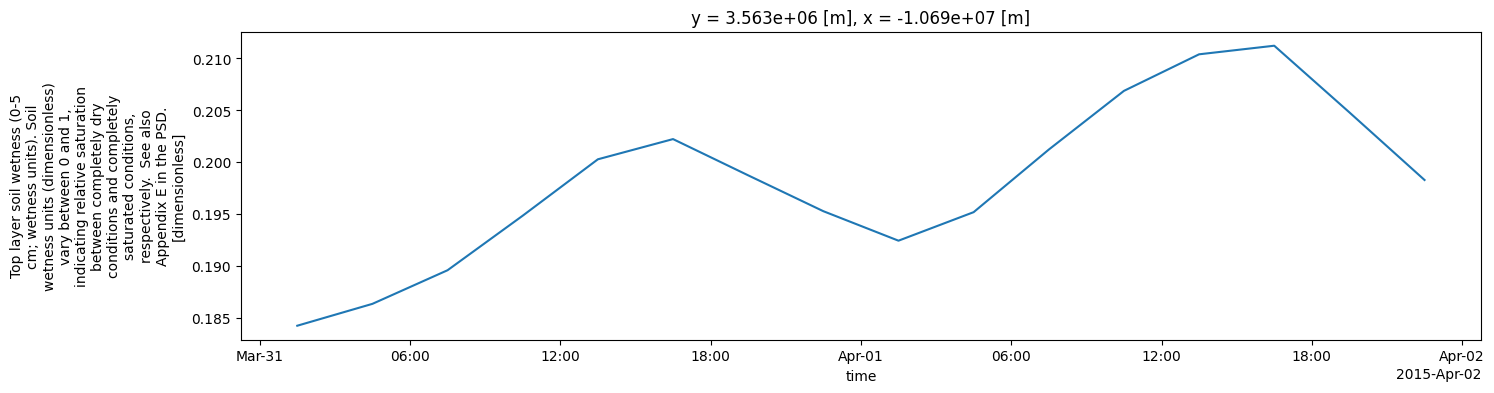

In [21]:
%%time 

da.plot(figsize=(16,4))

CPU times: user 1.21 s, sys: 309 ms, total: 1.52 s
Wall time: 3.8 s


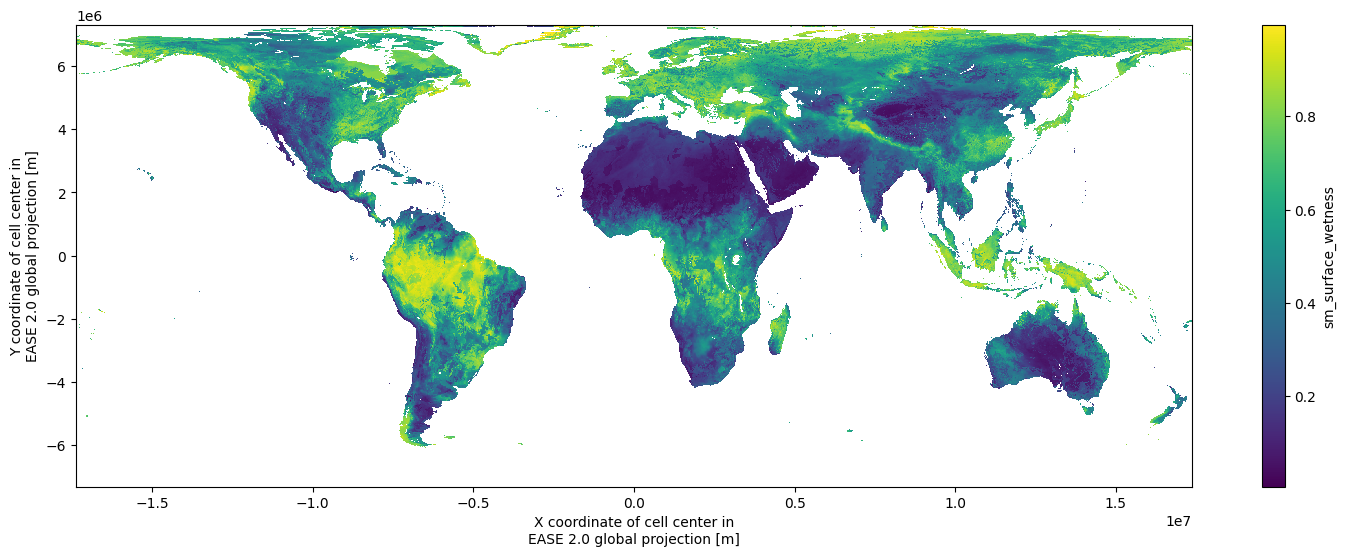

In [22]:
%%time

ds.sm_surface_wetness.mean(dim="time").plot(figsize=(18,6))